In [1]:
import openpathsampling as paths
import numpy as np
import openpathsampling.engines.msm as msm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mat = np.array([
        [0.95,0.05,0.0,0.0],
        [0.05,0.94,0.01,0.0],
        [0.0,0.01,0.94,0.05],
        [0.0,0.0,0.05,0.95]
    ])

In [3]:
engine = msm.Engine(mat)

In [4]:
snap = msm.Snapshot(
    state=0,
    engine=engine
)

In [5]:
engine.current_snapshot = snap

In [6]:
%%time
traj = engine.generate_n_frames(1000)

CPU times: user 52.8 ms, sys: 11.9 ms, total: 64.8 ms
Wall time: 57.3 ms


In [7]:
cv = paths.CV_Function('state', lambda snap: snap.state)

In [8]:
stateA = paths.CVRangeVolume(cv, -0.1, 0.1)
stateB = paths.CVRangeVolume(cv, 2.9, 3.1)

In [9]:
intA = paths.CVRangeVolume(cv, -0.1, 1.1)
intB = paths.CVRangeVolume(cv, 1.9, 3.1)

In [10]:
# mstis = paths.MSTISNetwork([
#     (stateA, [stateA, intA], cv),
#     (stateB, [stateB, intB], cv)
# ])

In [11]:
ensA2B = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB)),        
    ])
ensB2A = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),        
    ])

In [12]:
first_AB_list = ensA2B.split(traj)
firstAB = first_AB_list[0].state

In [13]:
first_BA_list = ensB2A.split(traj)
firstBA = first_AB_list[0].state

In [14]:
network = paths.TPSNetwork(stateA, stateB)

In [15]:
scheme = paths.OneWayShootingMoveScheme(network, selector=paths.UniformSelector(), engine=engine)

In [16]:
initial_conditions = scheme.initial_conditions_from_trajectories(first_AB_list + first_BA_list)

In [17]:
storage = paths.Storage("msm.nc", "w")

In [18]:
storage.set_caching_mode('analysis')

In [19]:
sampler = paths.PathSampling(storage=storage,
                             move_scheme=scheme,
                             globalstate=initial_conditions)

In [33]:
%%time
sampler.run(1000)

Working on Monte Carlo cycle number 2000.
DONE! Completed 2000 Monte Carlo cycles.
CPU times: user 1min 24s, sys: 8.36 s, total: 1min 32s
Wall time: 1min 28s


In [34]:
sum(map(len, storage.trajectories))

79708

In [38]:
len(storage.trajectories)

2001

In [39]:
path_lengths = [len(step.active[0].trajectory) for step in storage.steps]

Maximum: 157 (1570)
Average: 37.07 (370.69)


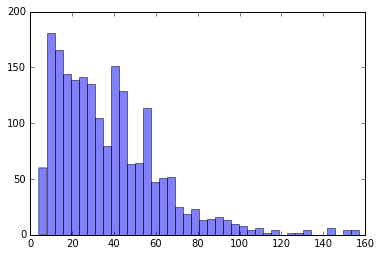

In [41]:
print "Maximum:", max(path_lengths), "("+str(max(path_lengths)*engine.snapshot_timestep)+")"
print "Average:", "{0:.2f}".format(np.mean(path_lengths)), "("+"{0:.2f}".format(np.mean(path_lengths)*engine.snapshot_timestep)+")"
plt.hist(path_lengths, bins=40, alpha=0.5);


In [25]:
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

In [42]:
history = ops_vis.PathTree(
    storage.steps[0:],
    ops_vis.ReplicaEvolution(
        replica=0
    )
)
print len(list(history.samples))

759


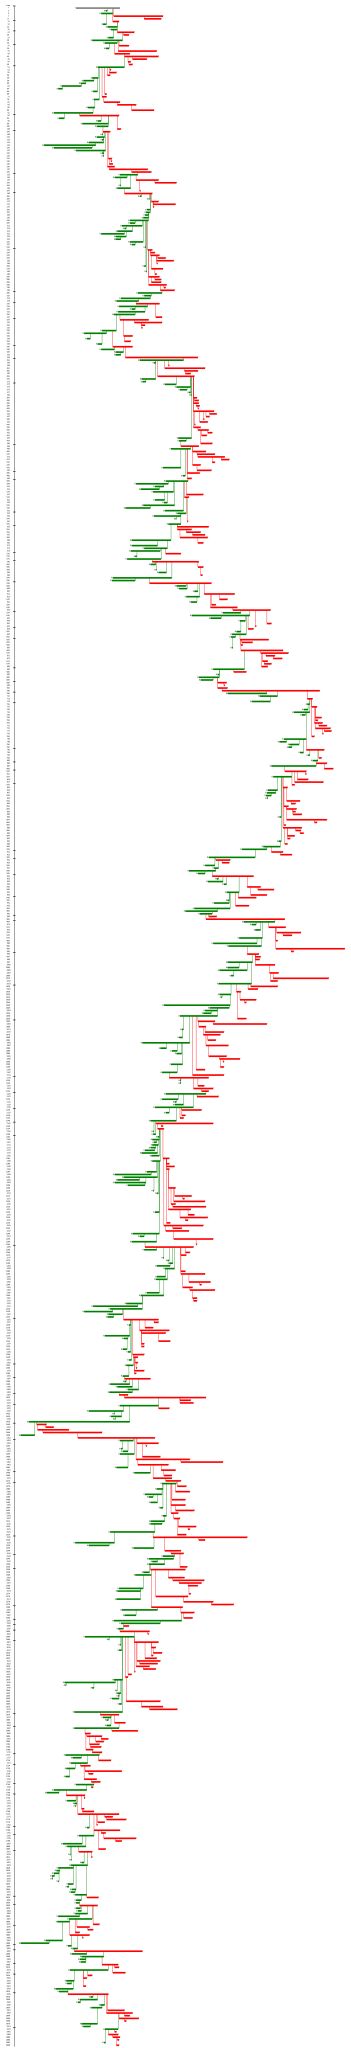

In [43]:
SVG(history.svg())